# ts_for_hyperparameter_optim

## Using Thompson Sampling for hyperparameter optimization

In this Notebook, we use Thompson Sampling for a rather unusual and uncommon application: hyperparameter optimization (or the optimization of arbitrary functions).

In [1]:
# plotting inline
%matplotlib inline

# working directory
import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_predict
from sklearn import datasets
from sklearn.metrics import r2_score

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

## Optimization of non-differentiable and non-convex functions

Before we delve into actual hyperparameter optimization, let us illustrate with a simpler example, but rather challenging: a 1D cut of the Ackley function.

In [2]:
# defining the function, y=0 to get a 1D cut at the origin
def ackley_1d(x, y=0):
    
    # the formula is rather large
    out = (-20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) 
           - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
           + np.e + 20)
    
    # returning
    return out

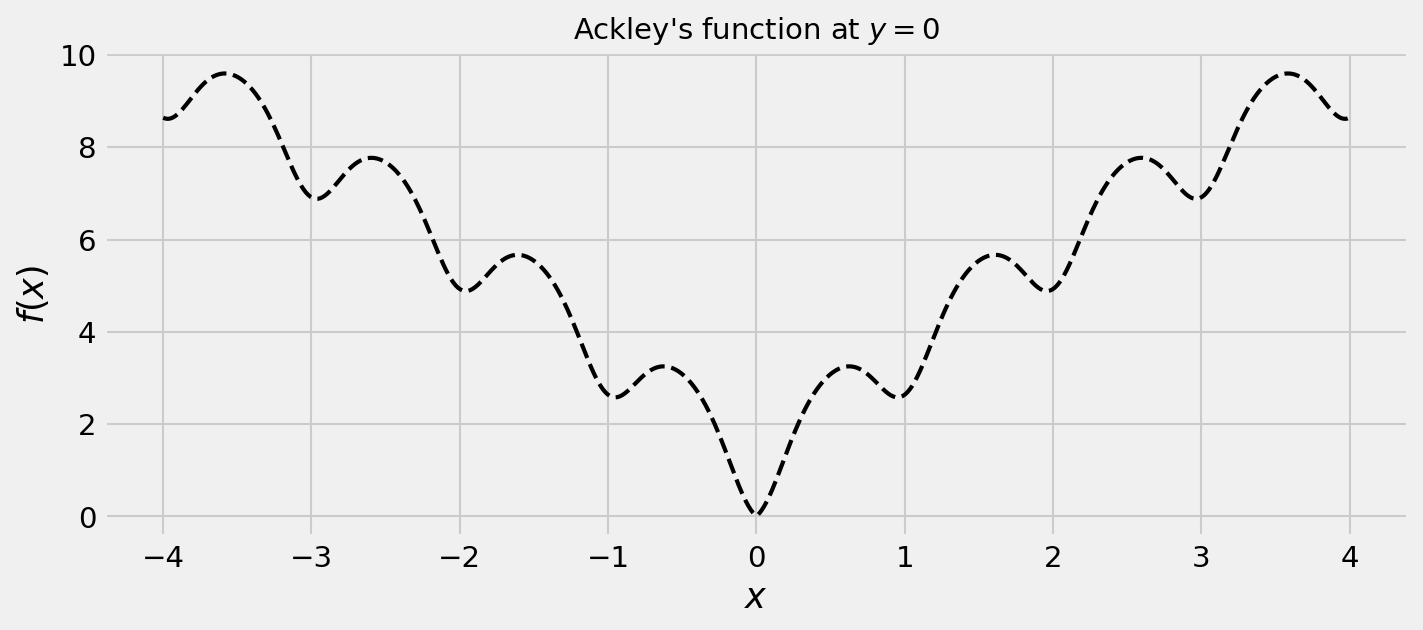

In [3]:
# clearing past figures
plt.close('all')

# let us view the function
plt.figure(figsize=[10,4], dpi=150)

# data
X = np.linspace(-4, 4, 500)
Y = ackley_1d(X)

# plotting
plt.plot(X, Y, 'k--',linewidth=2); 
plt.title("""Ackley's function at $y=0$""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.show();

The Ackley's function has a lot of local minima, therefore it's not convex. This makes harder for us to achive our goal to minimize it. Furthermore, we will add a twist: we will not make the function's derivatives available. This way, we're closer to a real hyperparameter optimization problem.

First, we need a method that can approximate this function and also calculate the uncertainty over the approximation. Let us use a Gaussian Process.

## Gaussian Process

Gaussian Processes are supervised learning methods that are non-parametric, unlike the Bayesian Logistic Regression we've seen earlier. Instead of trying to learn a posterior distribution over the *parameters of a function* $f(x) = \theta_0 + \theta_1 \cdot x + \epsilon$ we learn a posterior distribution over *all the functions*.

We specify how smooth the functions will be through covariance functions (kernels), which calculates the similarity between samples. If we enforce that similar points in input space produce similar outputs, we have a smooth function. I recommend [this](http://katbailey.github.io/post/gaussian-processes-for-dummies/) tutorial and [this](https://www.cs.toronto.edu/~hinton/csc2515/notes/gp_slides_fall08.pdf) for further reading. Also, these [classes](https://www.youtube.com/watch?v=4vGiHC35j9s) are very nice.

Let us try to fit a Gaussian Process to some random samples of the Ackley's function.  

In [4]:
# let us draw 20 random samples of the Ackley's function
x_observed = np.random.uniform(-4, 4, 20)
y_observed = ackley_1d(x_observed)

In [5]:
# let us use the Matern kernel
K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

# instance of GP
gp = GaussianProcessRegressor(kernel=K)

# fitting the GP
gp.fit(x_observed.reshape(-1,1), y_observed)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=1.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [6]:
# let us check the learned model over all of the input space
X_ = np.linspace(-4, 4, 500)
y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)

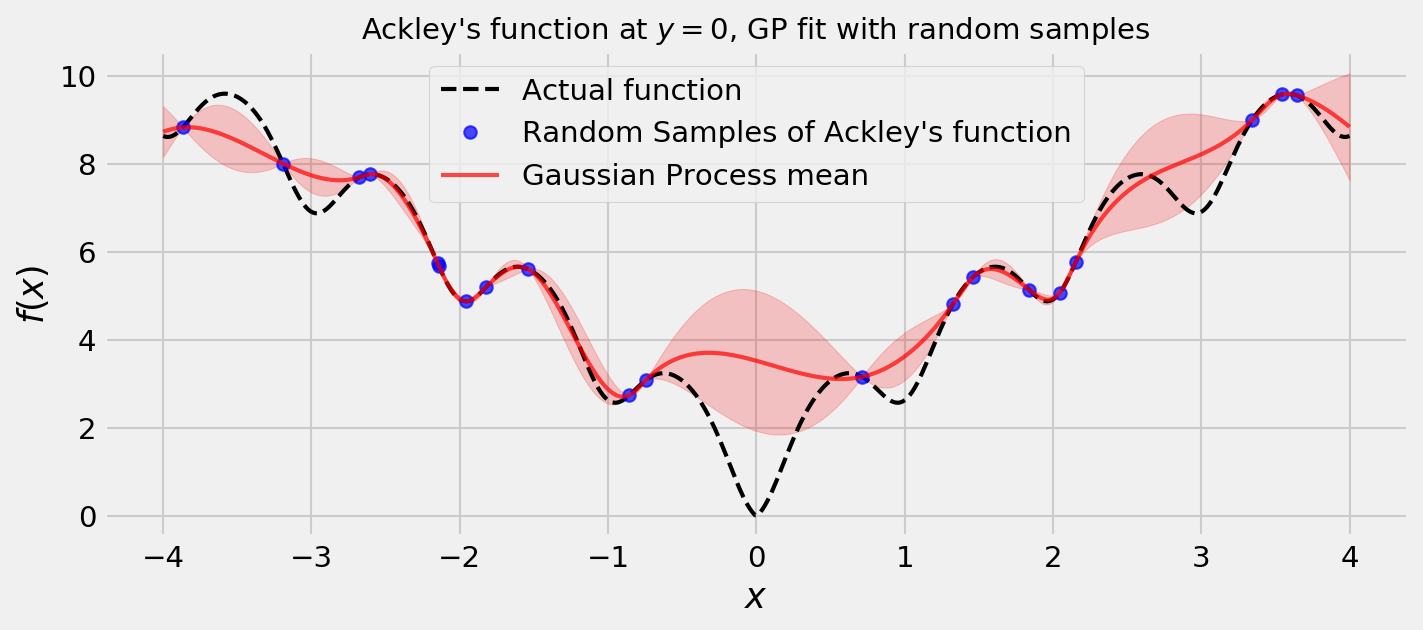

In [7]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[10,4], dpi=150)

# data
Y = ackley_1d(X_)

# plotting
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');
plt.plot(x_observed, y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=0.7)
plt.plot(X_, y_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='r')
plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

Cool! And what about the posterior over functions? Can we draw samples from it? Yes! And remember, the samples from the gaussian process posterior are functions themselves! Let us observe.

In [8]:
# function samples
y_samples = gp.sample_y(X_.reshape(-1,1), 10)

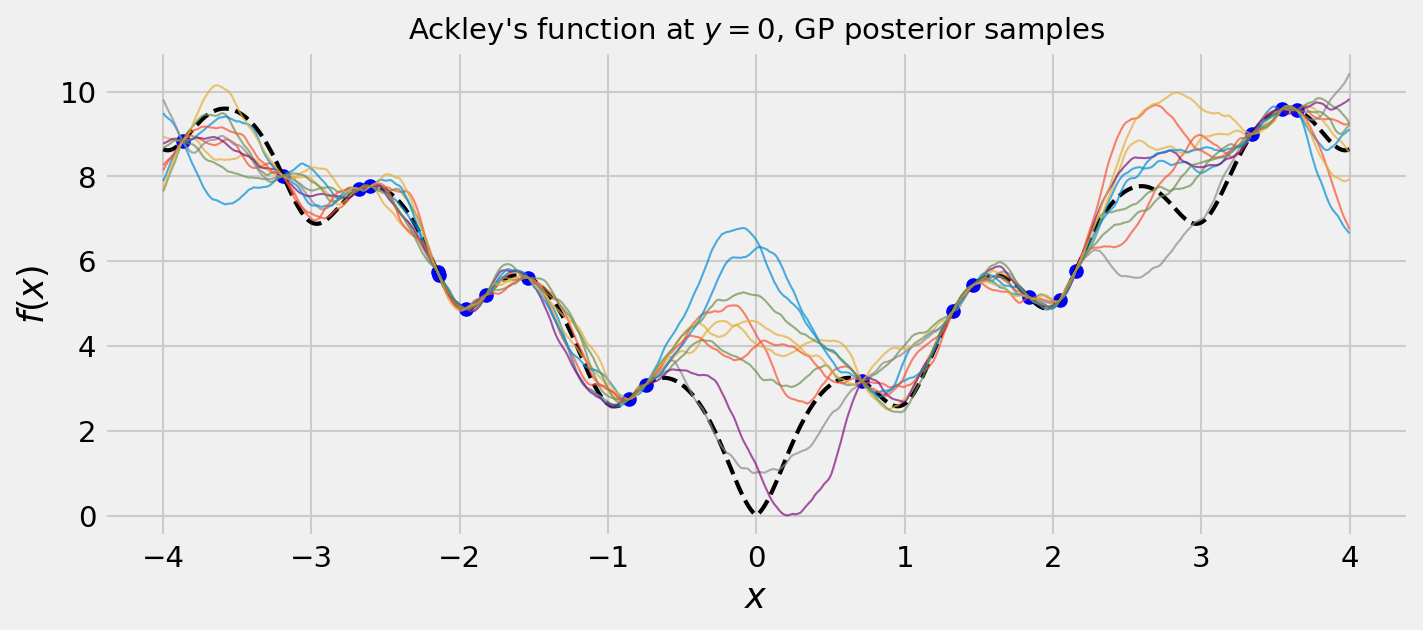

In [9]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[10,4], dpi=150)

# plotting random observations of function
plt.plot(x_observed, y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=1.0)
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');


# plotting all the posteriors
for posterior_sample in y_samples.T:
    plt.plot(X_, posterior_sample, label="""Random Samples of Ackley's function""", alpha=0.7, linewidth=1)

# title and labels    
plt.title("""Ackley's function at $y=0$, GP posterior samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.show();

## Thompson Sampling for a GP

Ok. So we learned how a GP works, and how we can draw *functions* from the posterior distribution it learns. So, now, how do we use Thompson Sampling with it? It's very simple:

1. Fit the GP to the observations we have
2. Draw one sample (a function) from the posterior
3. Choose next point as the optimum of the sample

The randomness of Thompson Sampling comes from the posterior sample. After we have it, we can just use its minimum as our next point. Let us implement this.

In [10]:
# our TS-GP optimizer
class ThompsonSamplingGP:
    
    # initialization
    def __init__(self, n_random_draws, objective, x_bounds, interval_resolution=1000):
                
        # number of random samples before starting the optimization
        self.n_random_draws = n_random_draws
        
        # the objective is the function we're trying to optimize
        self.objective = objective
        
        # the bounds tell us the interval of x we can work
        self.bounds = x_bounds
        
        # interval resolution is defined as how many points we will use to 
        # represent the posterior sample
        # we also define the x grid
        self.interval_resolution = interval_resolution
        self.X_grid = np.linspace(self.bounds[0], self.bounds[1], self.interval_resolution)
        
        # also initializing our design matrix and target variable
        self.X = np.array([]); self.y = np.array([])
        
    # fitting process
    def fit(self, X, y):
        
        # let us use the Matern kernel
        K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

        # instance of GP
        gp = GaussianProcessRegressor(kernel=K)

        # fitting the GP
        gp.fit(X, y)
        
        # return the fitted model
        return gp
    
    # process of choosing next point
    def choose_next_sample(self):
        
        # if we do not have enough samples, sample randomly from bounds
        if self.X.shape[0] < self.n_random_draws:
            next_sample = np.random.uniform(self.bounds[0], self.bounds[1],1)[0]
        
        # if we do, we fit the GP and choose the next point based on the posterior draw minimum
        else:
            # 1. Fit the GP to the observations we have
            self.gp = self.fit(self.X.reshape(-1,1), self.y)
            
            # 2. Draw one sample (a function) from the posterior
            posterior_sample = self.gp.sample_y(self.X_grid.reshape(-1,1), 1).T[0]
            
            # 3. Choose next point as the optimum of the sample
            which_min = np.argmin(posterior_sample)
            next_sample = self.X_grid[which_min]
        
            # let us also get the std from the posterior, for visualization purposes
            posterior_mean, posterior_std = self.gp.predict(self.X_grid.reshape(-1,1), return_std=True)
        
        # let us observe the objective and append this new data to our X and y
        next_observation = self.objective(next_sample)
        self.X = np.append(self.X, next_sample)
        self.y = np.append(self.y, next_observation)
        
        # return everything if possible
        try:
            # returning values of interest
            return self.X, self.y, self.X_grid, posterior_sample, posterior_mean, posterior_std
        
        # if not, return whats possible to return
        except:
            return (self.X, self.y, self.X_grid, np.array([np.mean(self.y)]*self.interval_resolution), 
                    np.array([np.mean(self.y)]*self.interval_resolution), np.array([0]*self.interval_resolution))

In [11]:
# function to create an animation with the visualization
def ts_gp_animation_ackley(ts_gp, max_rounds):
    
    # dict for accumulating runs
    round_dict = {}
    
    # loop for each round
    for round_id in range(max_rounds):
        
        # recording all the info
        X_observed, y_observed, X_grid, posterior_sample, posterior_mean, posterior_std = ts_gp.choose_next_sample()
        
        # adding to dict
        round_dict[round_id] = {'X_observed': X_observed, 
                                'y_observed': y_observed, 
                                'X_grid': X_grid,
                                'posterior_sample': posterior_sample,
                                'posterior_mean': posterior_mean,
                                'posterior_std': posterior_std}
    
    # plotting!
    fig, ax = plt.subplots(figsize=[10,4], dpi=150)
    
    # plotting first iteration
    ax.plot(X, Y, 'k--', linewidth=2, label='Actual function');
    ax.plot(round_dict[0]['X_observed'], round_dict[0]['y_observed'], 'bo', label="""GP-Chosen Samples of Ackley's function""", alpha=0.7)
    ax.plot(round_dict[0]['X_grid'], round_dict[0]['posterior_sample'], 'r', linewidth=2, label='Sample from the posterior', alpha=0.7)
    ax.fill_between(round_dict[0]['X_grid'], round_dict[0]['posterior_mean'] - round_dict[0]['posterior_std'],
                     round_dict[0]['posterior_mean'] + round_dict[0]['posterior_std'], alpha=0.2, color='r')
    plt.title("""Ackley's function at $y=0$, TS-GP optimization""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$'); 
    ax.set_ylim(-0.5, 10);
        
    # function for updating
    def animate(i):
        ax.clear()
        ax.plot(X, Y, 'k--', linewidth=2, label='Actual function');
        ax.plot(round_dict[i]['X_observed'], round_dict[i]['y_observed'], 'bo', label="""GP-Chosen Samples of Ackley's function""", alpha=0.7)
        ax.plot(round_dict[i]['X_grid'], round_dict[i]['posterior_sample'], 'r', linewidth=2, label='Sample from the posterior', alpha=0.7)
        ax.fill_between(round_dict[i]['X_grid'], round_dict[i]['posterior_mean'] - round_dict[i]['posterior_std'],
                         round_dict[i]['posterior_mean'] + round_dict[i]['posterior_std'], alpha=0.2, color='r')
        plt.title("""Ackley's function at $y=0$, TS-GP optimization""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
        ax.set_ylim(-0.5, 10);
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=max_rounds, interval=3500, blit=True)

    # showing
    return HTML(anim.to_html5_video())

In [12]:
# instance of our TS-GP
ts_gp = ThompsonSamplingGP(n_random_draws=2, objective=ackley_1d, x_bounds=(-4,4))

In [13]:
# suppressing warnings, gp can complain at times
import warnings; warnings.filterwarnings("ignore")

In [14]:
# showing animnation
ts_gp_animation_ackley(ts_gp, 20)

For most of the times we run this code, we're going to see a good balance of exploration and exploitation. As we get closer to the global minimum,  the uncertainty is reduced, as the algorithm concentrated its efforts where it was more promising. For the other zones, we may have a large uncertainty, but this is fine since even with this uncertainty there's not a significant chance of improvement.

## Hyperparameter optimization

Now we face the real challenge. We're going to perform the same optimization methodology we did before, but with the difference that our objective function is the result of a cross-validation experiment and our $x$ is a hyperparameter of an algorithm. 

Let us try tuning a Lasso to solve the Diabetes dataset.

In [15]:
# loading the data
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]

In [16]:
# now let us devise our objective function
class LassoDiabetesObjective:
    
    # initialization with data
    def __init__(self, X_train, y_train):
        
        # storing
        self.X_train = X_train
        self.y_train = y_train
        
    # validation experiment
    def validation_experiment(self, exp_alpha):
        
        # instance of svm
        lasso = Lasso(alpha=10**exp_alpha)
        
        # instance of CV scheme
        k_fold = KFold(n_splits=3, shuffle=True, random_state=20171026)
        
        # fitting on train
        preds = cross_val_predict(lasso, self.X_train, self.y_train, cv=k_fold)
        
        # validation accuraccy
        cv_r2 = r2_score(self.y_train, preds)
        
        # returning negative as our function minimizes the objective
        return -cv_r2

In [17]:
# our hyperparamter tuning objetive
diabetes_obj = LassoDiabetesObjective(X, y)

In [18]:
# our instance of TS-GP
ts_gp = ThompsonSamplingGP(n_random_draws=2, objective=diabetes_obj.validation_experiment, x_bounds=(-12,2))

In [19]:
# function to create an animation with the visualization,now with diabetes data
def ts_gp_animation_diabetes(ts_gp, max_rounds):
    
    # dict for accumulating runs
    round_dict = {}
    
    # loop for each round
    for round_id in range(max_rounds):
        
        # recording all the info
        X_observed, y_observed, X_grid, posterior_sample, posterior_mean, posterior_std = ts_gp.choose_next_sample()
        
        # adding to dict
        round_dict[round_id] = {'X_observed': X_observed, 
                                'y_observed': -y_observed, 
                                'X_grid': X_grid,
                                'posterior_sample': -posterior_sample,
                                'posterior_mean': -posterior_mean,
                                'posterior_std': -posterior_std}
    
    # plotting!
    fig, ax = plt.subplots(figsize=[10,4], dpi=150)
    
    # plotting first iteration
    ax.plot(round_dict[0]['X_grid'], round_dict[0]['posterior_mean'], 'r', linewidth=2, label='Actual function');
    ax.plot(round_dict[0]['X_observed'], round_dict[0]['y_observed'], 'bo', label="""GP-Chosen Samples of Ackley's function""", alpha=0.7)
    ax.plot(round_dict[0]['X_grid'], round_dict[0]['posterior_sample'], 'g', linewidth=2, label='Sample from the posterior', alpha=0.7)
    ax.fill_between(round_dict[0]['X_grid'], round_dict[0]['posterior_mean'] - round_dict[0]['posterior_std'],
                     round_dict[0]['posterior_mean'] + round_dict[0]['posterior_std'], alpha=0.2, color='r')
    plt.title("""Tuning of Lasso's alpha, TS-GP optimization""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$'); 
    ax.set_ylim(-0.5, 1.0);
        
    # function for updating
    def animate(i):
        ax.clear()
        ax.plot(round_dict[i]['X_grid'], round_dict[i]['posterior_mean'], 'r', linewidth=2, label='Actual function');
        ax.plot(round_dict[i]['X_observed'], round_dict[i]['y_observed'], 'bo', label="""GP-Chosen Samples of Ackley's function""", alpha=0.7)
        ax.plot(round_dict[i]['X_grid'], round_dict[i]['posterior_sample'], 'g', linewidth=2, label='Sample from the posterior', alpha=0.7)
        ax.fill_between(round_dict[i]['X_grid'], round_dict[i]['posterior_mean'] - round_dict[0]['posterior_std'],
                         round_dict[i]['posterior_mean'] + round_dict[i]['posterior_std'], alpha=0.2, color='r')
        plt.title("""Tuning of Lasso's alpha, TS-GP optimization""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$'); 
        ax.set_ylim(-0.5, 1.0);
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=max_rounds, interval=3500, blit=True)

    # showing
    return HTML(anim.to_html5_video())

In [20]:
# showing animnation
ts_gp_animation_diabetes(ts_gp, 20)

In most of the runs, the optimization will be very easy for our TS-GP methodology. The reader can easily expand the code to the multivariate case, where we have many decision variables and our TS-GP will be even more useful.   

## Conclusion

In this notebook, we used a model which computes a posterior distribution not on parameters, but *functions*, given the data. This way, we can sample these functions and use them in a Thompson Sampling-esque manner to address exploration/exploitation for optimizing non-convex, non-differentiable functions, like a hyperparameter tuning problem.

For further information about research in hyperparameter tuning (and a little more!), refer to the [AutoML website](http://www.ml4aad.org/automl/). Not limited to just hyperparameter tuning, research in the field proposes a completely automatic model building and selection process, with every moving part being optimized by Bayesian methods.